In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from ACAgraphML.Dataset import ZINC_Dataset

%load_ext autoreload
%autoreload 2

In [2]:
dataset_train = ZINC_Dataset.SMALL_TRAIN.load()
dataset_val = ZINC_Dataset.SMALL_VAL.load()

In [3]:
from ACAgraphML.Dataset import BONDataset

bonDataset_train = BONDataset(dataset_train)
bonDataset_val = BONDataset(dataset_val, useSavedState=True)

# Just BON

In [4]:
bonDataset_train[0]

(tensor([21,  4,  3,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0]),
 tensor([0.7375, 0.0679, 0.1384, 0.0000, 0.0000, 0.0562, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000]),
 tensor([46, 18,  0]),
 tensor([0.8350]))

In [5]:
xt = [torch.cat([d[0], d[3]]) for d in bonDataset_train]
xt = torch.stack(xt, dim=0)
x = xt[:, :-1]
t = xt[:, -1]

xt_val = [torch.cat([d[0], d[3]]) for d in bonDataset_val]
xt_val = torch.stack(xt_val, dim=0)
x_val = xt_val[:, :-1]
t_val = xt_val[:, -1]
print(x.shape, t.shape)
print(x_val.shape, t_val.shape)

torch.Size([10000, 21]) torch.Size([10000])
torch.Size([1000, 21]) torch.Size([1000])


In [6]:
#Random forset
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
rf.fit(x.numpy(), t.numpy())

,n_estimators,1000
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [7]:
y =  rf.predict(x.numpy())
y = torch.tensor(y, dtype=torch.float32)
y_val = rf.predict(x_val.numpy())
y_val = torch.tensor(y_val, dtype=torch.float32)

# Compute metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(t.numpy(), y.numpy())
mse = mean_squared_error(t.numpy(), y.numpy())
r2 = r2_score(t.numpy(), y.numpy())

print(f"TRAIN: MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")

mae_val = mean_absolute_error(t_val.numpy(), y_val.numpy())
mse_val = mean_squared_error(t_val.numpy(), y_val.numpy())
r2_val = r2_score(t_val.numpy(), y_val.numpy())

print(f"VAL: MAE: {mae_val:.4f}, MSE: {mse_val:.4f}, R2: {r2_val:.4f}")

TRAIN: MAE: 0.4129, MSE: 0.6286, R2: 0.8445
VAL: MAE: 0.8026, MSE: 1.8455, R2: 0.5314


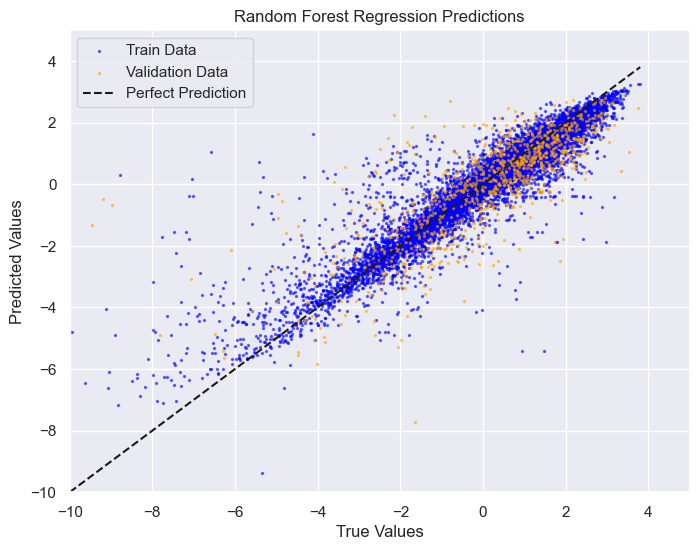

In [8]:
#Plot the predicion curve
plt.figure(figsize=(8, 6))
plt.scatter(t.numpy(), y.numpy(), alpha=0.5, label='Train Data', color='blue', s=2)
plt.scatter(t_val.numpy(), y_val.numpy(), alpha=0.5, label='Validation Data', color='orange', s=2)
plt.plot([t.min(), t.max()], [t.min(), t.max()], 'k--', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression Predictions')
plt.legend()
plt.xlim(-10, 5)
plt.ylim(-10, 5)
plt.show()

In [25]:
#SVR
from sklearn.svm import SVR
svr = SVR(kernel='rbf', C=10.0, epsilon=0.1)
svr.fit(x.numpy(), t.numpy())
#print number of support vectors and percentage of support vectors
print(f"Number of support vectors: {len(svr.support_)}")
print(f"Percentage of support vectors: {len(svr.support_) / len(t) * 100:.2f}%")
y_svr = svr.predict(x.numpy())
y_svr = torch.tensor(y_svr, dtype=torch.float32)
y_val_svr = svr.predict(x_val.numpy())
y_val_svr = torch.tensor(y_val_svr, dtype=torch.float32)
# Compute metrics for SVR
mae_svr = mean_absolute_error(t.numpy(), y_svr.numpy())
mse_svr = mean_squared_error(t.numpy(), y_svr.numpy())
r2_svr = r2_score(t.numpy(), y_svr.numpy())
print(f"SVR TRAIN: MAE: {mae_svr:.4f}, MSE: {mse_svr:.4f}, R2: {r2_svr:.4f}")
mae_val_svr = mean_absolute_error(t_val.numpy(), y_val_svr.numpy())
mse_val_svr = mean_squared_error(t_val.numpy(), y_val_svr.numpy())
r2_val_svr = r2_score(t_val.numpy(), y_val_svr.numpy())
print(f"SVR VAL: MAE: {mae_val_svr:.4f}, MSE: {mse_val_svr:.4f}, R2: {r2_val_svr:.4f}")

Number of support vectors: 8631
Percentage of support vectors: 86.31%
SVR TRAIN: MAE: 0.6127, MSE: 1.4851, R2: 0.6327
SVR VAL: MAE: 0.6322, MSE: 1.5020, R2: 0.6187


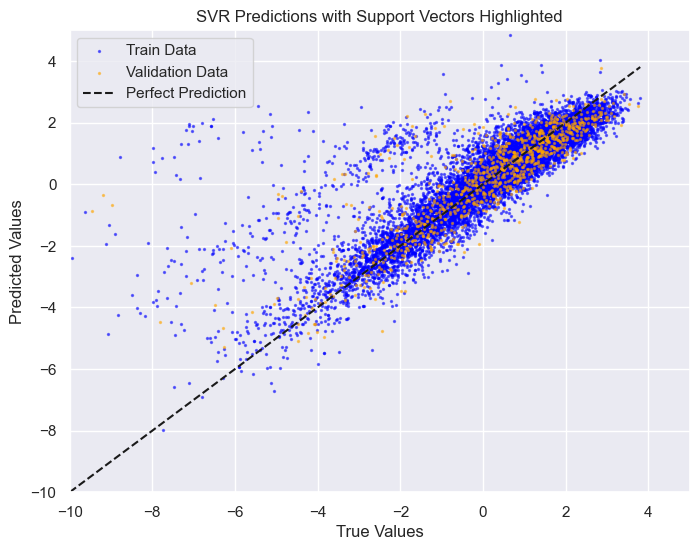

In [26]:
#Plot  the SVR prediction curve highlighting the support vectors
plt.figure(figsize=(8, 6))
plt.scatter(t.numpy(), y_svr.numpy(), alpha=0.5, label='Train Data', color='blue', s=2)
plt.scatter(t_val.numpy(), y_val_svr.numpy(), alpha=0.5, label='Validation Data', color='orange', s=2)
# Highlight datapoints corresponding to the support vectors in the training set
support_indices = svr.support_
# plt.scatter(t.numpy()[support_indices], y_svr.numpy()[support_indices], color='red', label='Support Vectors', s=2, alpha=0.8)
plt.plot([t.min(), t.max()], [t.min(), t.max()], 'k--', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('SVR Predictions with Support Vectors Highlighted')
plt.legend()
plt.xlim(-10, 5)
plt.ylim(-10, 5)
plt.show()

### Investigate the bands

In [34]:
from ACAgraphML.Plotting import plotGraph

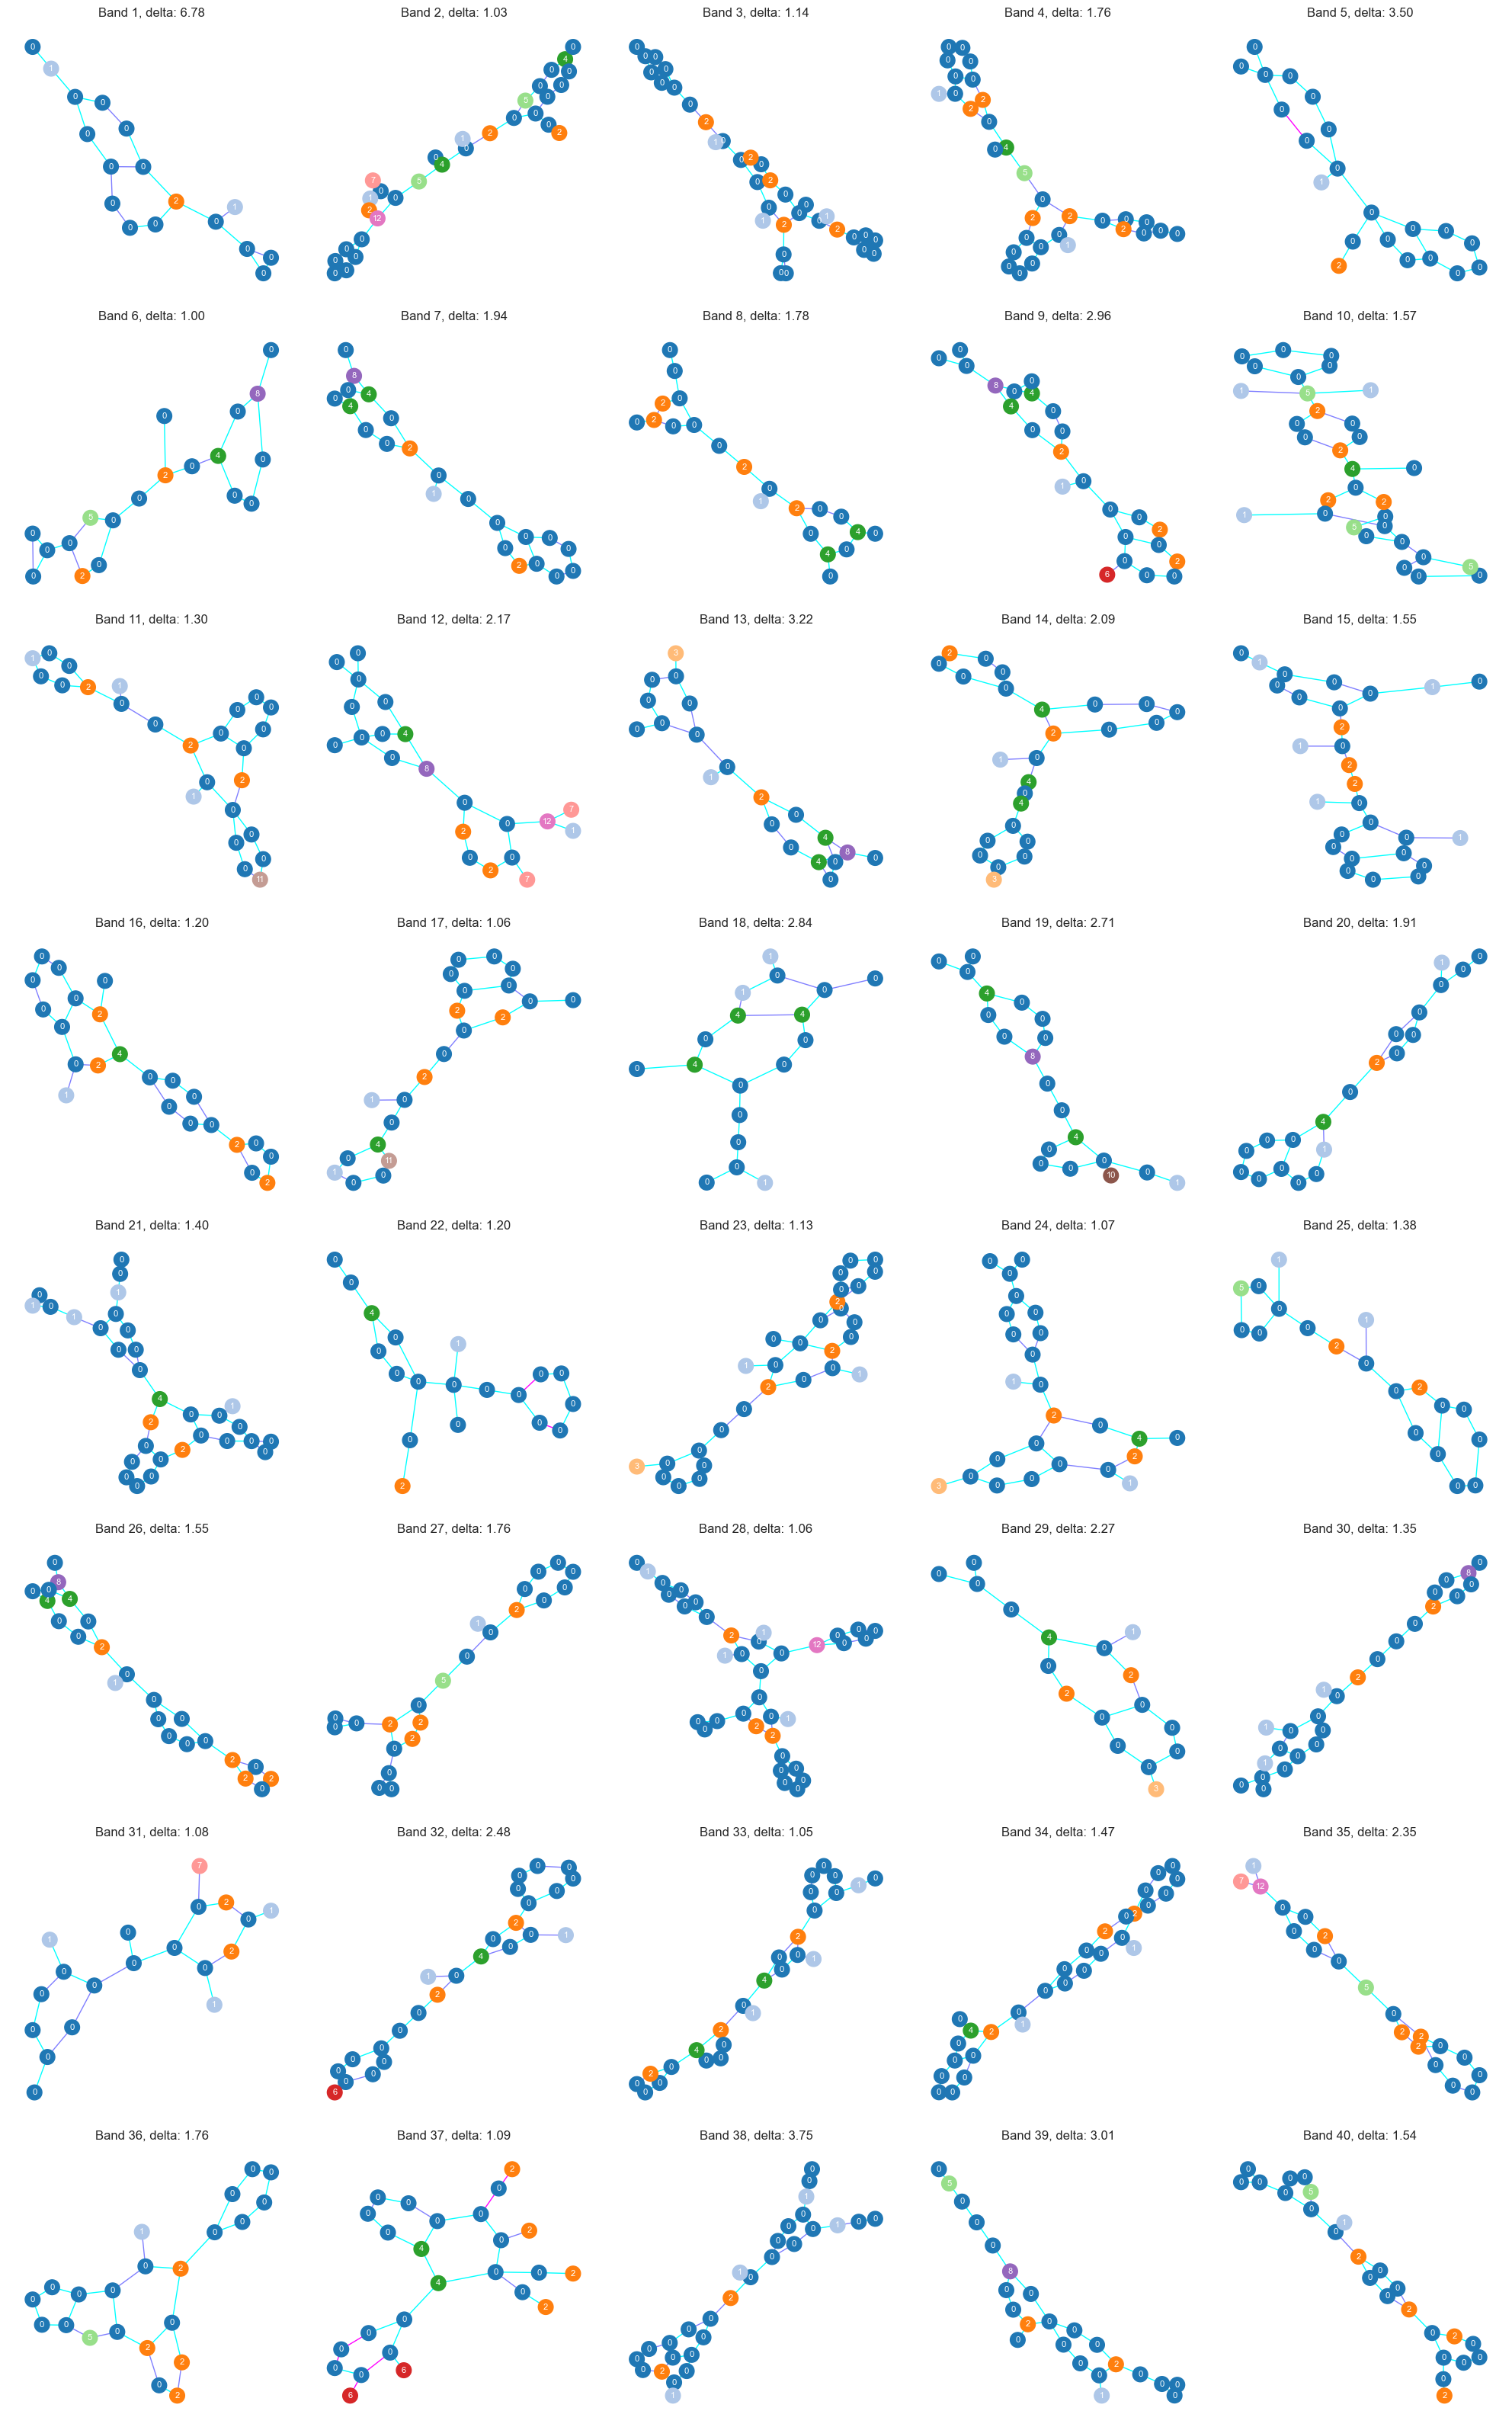

In [39]:
deltas = y_svr - y
deltas_bands = deltas[deltas > 1]
bands = dataset_train[deltas > 1]

#Plot 20 random bands using plotGraph
fig, axes = plt.subplots(8, 5, figsize=(20, 32))
axes = axes.flatten()
for i, band in enumerate(bands[:40]):
    ax = axes[i]
    plotGraph(band, ax=ax, title=f"Band {i+1}, delta: {deltas_bands[i]:.2f}")
plt.tight_layout()
plt.show()

In [11]:
# import numpy as np
# from ray import tune
# from ray.air import session
# from sklearn.svm import SVR
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import mean_absolute_error

# def train_svr(config):
#     # config contains the hyperparameters to try
#     model = SVR(
#         C=config["C"],
#         epsilon=config["epsilon"],
#         kernel=config["kernel"]
#     )
#     # Evaluate on the validation set (no cross-validation, just one pass)
#     model.fit(x.numpy(), t.numpy())
#     score = model.score(x_val.numpy(), t_val.numpy())
#     # Use negative mean absolute error as the metric
#     y_pred = model.predict(x_val.numpy())
#     score = -mean_absolute_error(t_val.numpy(), y_pred)
#     scores = [score]
#     # Report the mean score to Ray Tune
#     session.report({"mean_cv_score": np.mean(scores)})

# search_space = {
#     "C": tune.grid_search([0.1, 1.0, 10.0]),
#     "epsilon": tune.grid_search([0.01, 0.1, 0.2]),
#     "kernel": tune.grid_search(["linear", "rbf"])
# }

# tuner = tune.Tuner(
#     train_svr,
#     param_space=search_space,
#     tune_config=tune.TuneConfig(
#         metric="mean_cv_score",
#         mode="max"  # Because neg MAE, higher is better
#     )
# )
# results = tuner.fit()

# # Extract results
# df = results.get_dataframe()
# best_result = df.loc[df["mean_cv_score"].idxmax()]
# best_params = {
#     "C": best_result["config/C"],
#     "epsilon": best_result["config/epsilon"],
#     "kernel": best_result["config/kernel"]
# }
# print("Best parameters found:", best_params)
# print("Best score (negative MAE):", best_result["mean_cv_score"])

# # Fit and evaluate the best model
# best_svr = SVR(**best_params)
# best_svr.fit(x.numpy(), t.numpy())

# y_best_svr = best_svr.predict(x.numpy())
# y_best_svr = torch.tensor(y_best_svr, dtype=torch.float32)
# y_val_best_svr = best_svr.predict(x_val.numpy())
# y_val_best_svr = torch.tensor(y_val_best_svr, dtype=torch.float32)

# # Compute metrics for the best SVR model
# mae_best_svr = mean_absolute_error(t.numpy(), y_best_svr.numpy())
# mse_best_svr = mean_squared_error(t.numpy(), y_best_svr.numpy())
# r2_best_svr = r2_score(t.numpy(), y_best_svr.numpy())
# print(f"Best SVR TRAIN: MAE: {mae_best_svr:.4f}, MSE: {mse_best_svr:.4f}, R2: {r2_best_svr:.4f}")
# mae_val_best_svr = mean_absolute_error(t_val.numpy(), y_val_best_svr.numpy())
# mse_val_best_svr = mean_squared_error(t_val.numpy(), y_val_best_svr.numpy())
# r2_val_best_svr = r2_score(t_val.numpy(), y_val_best_svr.numpy())
# print(f"Best SVR VAL: {mae_val_best_svr:.4f}, MSE: {mse_val_best_svr:.4f}, R2: {r2_val_best_svr:.4f}")

# # Plotting results
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(df)), df["mean_cv_score"], tick_label=[
#     f'C={row["config/C"]},e={row["config/epsilon"]},k={row["config/kernel"]}' for _, row in df.iterrows()
# ], color='skyblue')
# plt.xlabel('Hyperparameters')
# plt.ylabel('Mean Test Score (Negative MAE)')
# plt.title('Ray Tune Grid Search Results for SVR Hyperparameters')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

In [12]:
#Xgboost
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=5000, learning_rate=0.01, max_depth=3, n_jobs=-1)
xgb.fit(x.numpy(), t.numpy())

y_xgb = xgb.predict(x.numpy())
y_xgb = torch.tensor(y_xgb, dtype=torch.float32)
y_val_xgb = xgb.predict(x_val.numpy())
y_val_xgb = torch.tensor(y_val_xgb, dtype=torch.float32)
# Compute metrics for XGBoost
mae_xgb = mean_absolute_error(t.numpy(), y_xgb.numpy())
mse_xgb = mean_squared_error(t.numpy(), y_xgb.numpy())
r2_xgb = r2_score(t.numpy(), y_xgb.numpy())
print(f"XGBoost TRAIN: MAE: {mae_xgb:.4f}, MSE: {mse_xgb:.4f}, R2: {r2_xgb:.4f}")
mae_val_xgb = mean_absolute_error(t_val.numpy(), y_val_xgb.numpy())
mse_val_xgb = mean_squared_error(t_val.numpy(), y_val_xgb.numpy())
r2_val_xgb = r2_score(t_val.numpy(), y_val_xgb.numpy())
print(f"XGBoost VAL: MAE: {mae_val_xgb:.4f}, MSE: {mse_val_xgb:.4f}, R2: {r2_val_xgb:.4f}")

XGBoost TRAIN: MAE: 0.6196, MSE: 1.2590, R2: 0.6886
XGBoost VAL: MAE: 0.6636, MSE: 1.4826, R2: 0.6236


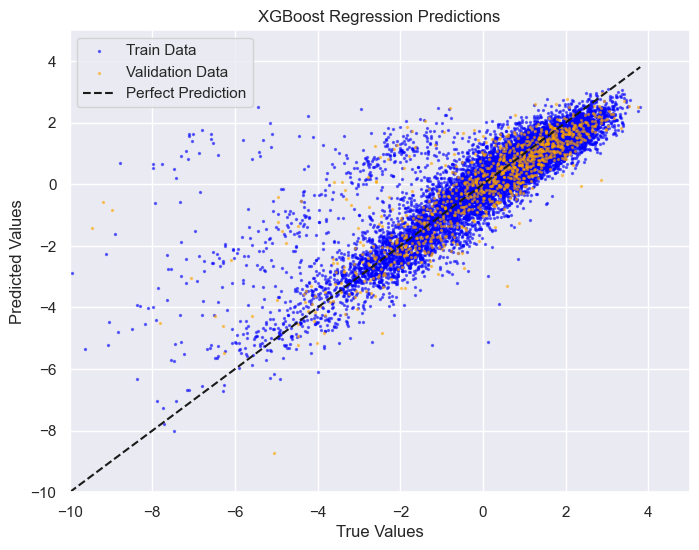

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(t.numpy(), y_xgb.numpy(), alpha=0.5, label='Train Data', color='blue', s=2)
plt.scatter(t_val.numpy(), y_val_xgb.numpy(), alpha=0.5, label='Validation Data', color='orange', s=2)
plt.plot([t.min(), t.max()], [t.min(), t.max()], 'k--', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost Regression Predictions')
plt.legend()
plt.xlim(-10, 5)
plt.ylim(-10, 5)
plt.show()

# Stady state corrected

In [14]:
bonDataset_train[0]

(tensor([21,  4,  3,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0]),
 tensor([0.7375, 0.0679, 0.1384, 0.0000, 0.0000, 0.0562, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000]),
 tensor([46, 18,  0]),
 tensor([0.8350]))

In [15]:
xt_steady = [torch.cat([d[1]*d[1].shape[0], d[-1]]) for d in bonDataset_train]
xt_steady = torch.stack(xt_steady, dim=0)
x_steady = xt_steady[:, :-1]
t_steady = xt_steady[:, -1]

xt_val_steady = [torch.cat([d[1]*d[1].shape[0], d[-1]]) for d in bonDataset_val]
xt_val_steady = torch.stack(xt_val_steady, dim=0)
x_val_steady = xt_val_steady[:, :-1]
t_val_steady = xt_val_steady[:, -1]
print(x_steady.shape, t_steady.shape)
print(x_val_steady.shape, t_val_steady.shape)

torch.Size([10000, 21]) torch.Size([10000])
torch.Size([1000, 21]) torch.Size([1000])


In [16]:
x_steady[0]

tensor([15.4869,  1.4251,  2.9070,  0.0000,  0.0000,  1.1811,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000])

In [17]:
#SVR on steady state
svr_steady = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_steady.fit(x_steady.numpy(), t_steady.numpy())
y_steady = svr_steady.predict(x_steady.numpy())
y_steady = torch.tensor(y_steady, dtype=torch.float32)
y_val_steady = svr_steady.predict(x_val_steady.numpy())
y_val_steady = torch.tensor(y_val_steady, dtype=torch.float32)
# Compute metrics for SVR on steady state
mae_steady = mean_absolute_error(t_steady.numpy(), y_steady.numpy())
mse_steady = mean_squared_error(t_steady.numpy(), y_steady.numpy())
r2_steady = r2_score(t_steady.numpy(), y_steady.numpy())
print(f"SVR STEADY TRAIN: MAE: {mae_steady:.4f}, MSE: {mse_steady:.4f}, R2: {r2_steady:.4f}")
mae_val_steady = mean_absolute_error(t_val_steady.numpy(), y_val_steady.numpy())
mse_val_steady = mean_squared_error(t_val_steady.numpy(), y_val_steady.numpy())
r2_val_steady = r2_score(t_val_steady.numpy(), y_val_steady.numpy())
print(f"SVR STEADY VAL: MAE: {mae_val_steady:.4f}, MSE: {mse_val_steady:.4f}, R2: {r2_val_steady:.4f}")

SVR STEADY TRAIN: MAE: 0.9621, MSE: 2.3693, R2: 0.4140
SVR STEADY VAL: MAE: 0.9302, MSE: 2.2195, R2: 0.4365


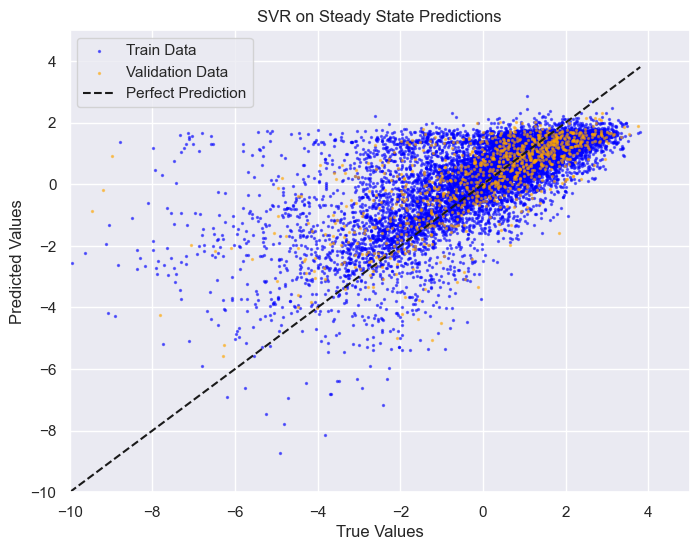

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(t_steady.numpy(), y_steady.numpy(), alpha=0.5, label='Train Data', color='blue', s=2)
plt.scatter(t_val_steady.numpy(), y_val_steady.numpy(), alpha=0.5, label='Validation Data', color='orange', s=2)
plt.plot([t_steady.min(), t_steady.max()], [t_steady.min(), t_steady.max()], 'k--', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('SVR on Steady State Predictions')
plt.legend()
plt.xlim(-10, 5)
plt.ylim(-10, 5)
plt.show()

RF STEADY TRAIN: MAE: 0.3605, MSE: 0.3670, R2: 0.9092
RF STEADY VAL: MAE: 0.9144, MSE: 2.0656, R2: 0.4756


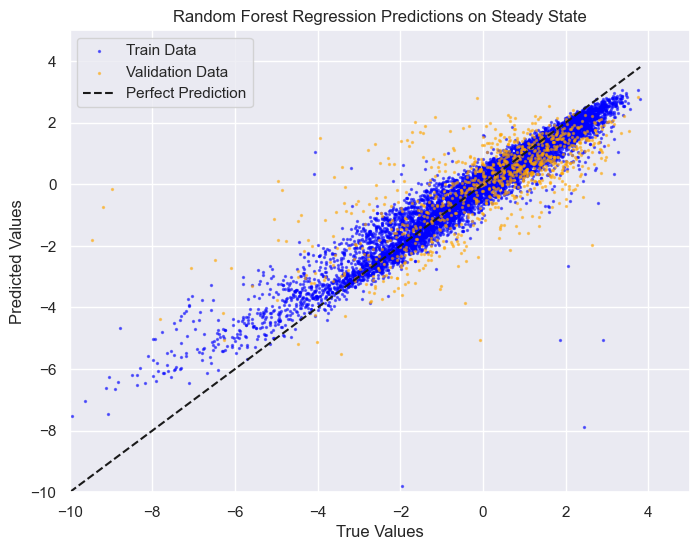

In [19]:
#Random forest on steady state
rf_steady = RandomForestRegressor(n_estimators=1000, n_jobs=-1, max_features='sqrt')
rf_steady.fit(x_steady.numpy(), t_steady.numpy())
y_steady_rf = rf_steady.predict(x_steady.numpy())
y_steady_rf = torch.tensor(y_steady_rf, dtype=torch.float32)
y_val_steady_rf = rf_steady.predict(x_val_steady.numpy())
y_val_steady_rf = torch.tensor(y_val_steady_rf, dtype=torch.float32)
# Compute metrics for Random Forest on steady state
mae_steady_rf = mean_absolute_error(t_steady.numpy(), y_steady_rf.numpy())
mse_steady_rf = mean_squared_error(t_steady.numpy(), y_steady_rf.numpy())
r2_steady_rf = r2_score(t_steady.numpy(), y_steady_rf.numpy())
print(f"RF STEADY TRAIN: MAE: {mae_steady_rf:.4f}, MSE: {mse_steady_rf:.4f}, R2: {r2_steady_rf:.4f}")
mae_val_steady_rf = mean_absolute_error(t_val_steady.numpy(), y_val_steady_rf.numpy())
mse_val_steady_rf = mean_squared_error(t_val_steady.numpy(), y_val_steady_rf.numpy())
r2_val_steady_rf = r2_score(t_val_steady.numpy(), y_val_steady_rf.numpy())
print(f"RF STEADY VAL: MAE: {mae_val_steady_rf:.4f}, MSE: {mse_val_steady_rf:.4f}, R2: {r2_val_steady_rf:.4f}")
plt.figure(figsize=(8, 6))
plt.scatter(t_steady.numpy(), y_steady_rf.numpy(), alpha=0.5, label='Train Data', color='blue', s=2)
plt.scatter(t_val_steady.numpy(), y_val_steady_rf.numpy(), alpha=0.5, label='Validation Data', color='orange', s=2)
plt.plot([t_steady.min(), t_steady.max()], [t_steady.min(), t_steady.max()], 'k--', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression Predictions on Steady State')
plt.legend()
plt.xlim(-10, 5)
plt.ylim(-10, 5)
plt.show()

XGBoost STEADY TRAIN: MAE: 0.6137, MSE: 1.0065, R2: 0.7511
XGBoost STEADY VAL: MAE: 0.8998, MSE: 2.0006, R2: 0.4921


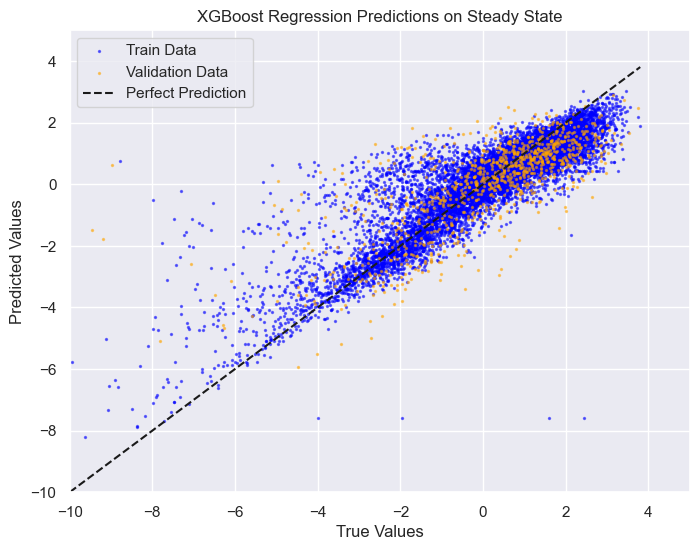

In [20]:
#XGboost on steady state
xgb_steady = XGBRegressor(n_estimators=5000, learning_rate=0.01, n_jobs=-1)
xgb_steady.fit(x_steady.numpy(), t_steady.numpy())
y_steady_xgb = xgb_steady.predict(x_steady.numpy())
y_steady_xgb = torch.tensor(y_steady_xgb, dtype=torch.float32)
y_val_steady_xgb = xgb_steady.predict(x_val_steady.numpy())
y_val_steady_xgb = torch.tensor(y_val_steady_xgb, dtype=torch.float32)
# Compute metrics for XGBoost on steady state
mae_steady_xgb = mean_absolute_error(t_steady.numpy(), y_steady_xgb.numpy())
mse_steady_xgb = mean_squared_error(t_steady.numpy(), y_steady_xgb.numpy())
r2_steady_xgb = r2_score(t_steady.numpy(), y_steady_xgb.numpy())
print(f"XGBoost STEADY TRAIN: MAE: {mae_steady_xgb:.4f}, MSE: {mse_steady_xgb:.4f}, R2: {r2_steady_xgb:.4f}")
mae_val_steady_xgb = mean_absolute_error(t_val_steady.numpy(), y_val_steady_xgb.numpy())
mse_val_steady_xgb = mean_squared_error(t_val_steady.numpy(), y_val_steady_xgb.numpy())
r2_val_steady_xgb = r2_score(t_val_steady.numpy(), y_val_steady_xgb.numpy())
print(f"XGBoost STEADY VAL: MAE: {mae_val_steady_xgb:.4f}, MSE: {mse_val_steady_xgb:.4f}, R2: {r2_val_steady_xgb:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(t_steady.numpy(), y_steady_xgb.numpy(), alpha=0.5, label='Train Data', color='blue', s=2)
plt.scatter(t_val_steady.numpy(), y_val_steady_xgb.numpy(), alpha=0.5, label='Validation Data', color='orange', s=2)
plt.plot([t_steady.min(), t_steady.max()], [t_steady.min(), t_steady.max()], 'k--', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost Regression Predictions on Steady State')
plt.legend()
plt.xlim(-10, 5)
plt.ylim(-10, 5)
plt.show()

# Degree distribution

In [21]:
from torch_geometric.transforms import OneHotDegree

In [22]:
oneHotDegTransform:OneHotDegree = OneHotDegree(max_degree=4)
degs_train = [oneHotDegTransform(graph).x[:, 2:] for graph in dataset_train]
bod_train = [d.sum(dim=0) for d in degs_train]
bod_train = torch.stack(bod_train, dim=0)

degs_val = [oneHotDegTransform(graph).x[:, 2:] for graph in dataset_val]
bod_val = [d.sum(dim=0) for d in degs_val]
bod_val = torch.stack(bod_val, dim=0)

x_bod_train = torch.cat([x, bod_train], dim=1)
t_bod_train = t
x_bod_val =  torch.cat([x_val, bod_val], dim=1)
t_bod_val = t_val
print(x_bod_train.shape, t_bod_train.shape)

torch.Size([10000, 25]) torch.Size([10000])


RF BOD TRAIN: MAE: 0.2837, MSE: 0.2744, R2: 0.9321
RF BOD VAL: MAE: 0.7413, MSE: 1.7305, R2: 0.5607


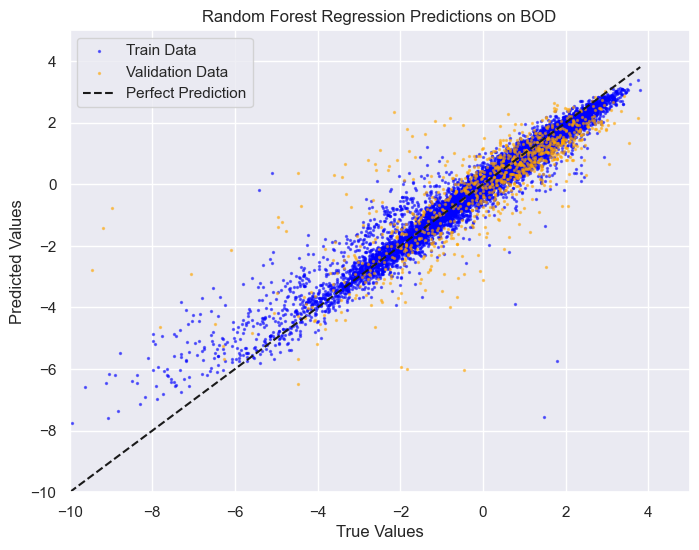

In [23]:
#random forest on BOD
rf_bod = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
rf_bod.fit(x_bod_train.numpy(), t_bod_train.numpy())
y_bod = rf_bod.predict(x_bod_train.numpy())
y_bod = torch.tensor(y_bod, dtype=torch.float32)
y_val_bod = rf_bod.predict(x_bod_val.numpy())
y_val_bod = torch.tensor(y_val_bod, dtype=torch.float32)
# Compute metrics for Random Forest on BOD
mae_bod = mean_absolute_error(t_bod_train.numpy(), y_bod.numpy())
mse_bod = mean_squared_error(t_bod_train.numpy(), y_bod.numpy())
r2_bod = r2_score(t_bod_train.numpy(), y_bod.numpy())
print(f"RF BOD TRAIN: MAE: {mae_bod:.4f}, MSE: {mse_bod:.4f}, R2: {r2_bod:.4f}")
mae_val_bod = mean_absolute_error(t_bod_val.numpy(), y_val_bod.numpy())
mse_val_bod = mean_squared_error(t_bod_val.numpy(), y_val_bod.numpy())
r2_val_bod = r2_score(t_bod_val.numpy(), y_val_bod.numpy())
print(f"RF BOD VAL: MAE: {mae_val_bod:.4f}, MSE: {mse_val_bod:.4f}, R2: {r2_val_bod:.4f}")
plt.figure(figsize=(8, 6))
plt.scatter(t_bod_train.numpy(), y_bod.numpy(), alpha=0.5,
            label='Train Data', color='blue', s=2)
plt.scatter(t_bod_val.numpy(), y_val_bod.numpy(), alpha=0.5,
            label='Validation Data', color='orange', s=2)
plt.plot([t_bod_train.min(), t_bod_train.max()],
         [t_bod_train.min(), t_bod_train.max()], 'k--', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression Predictions on BOD')
plt.legend()
plt.xlim(-10, 5)
plt.ylim(-10, 5)
plt.show()

XGBoost BOD TRAIN: MAE: 0.5327, MSE: 0.8072, R2: 0.8004
XGBoost BOD VAL: MAE: 0.6351, MSE: 1.4178, R2: 0.6400


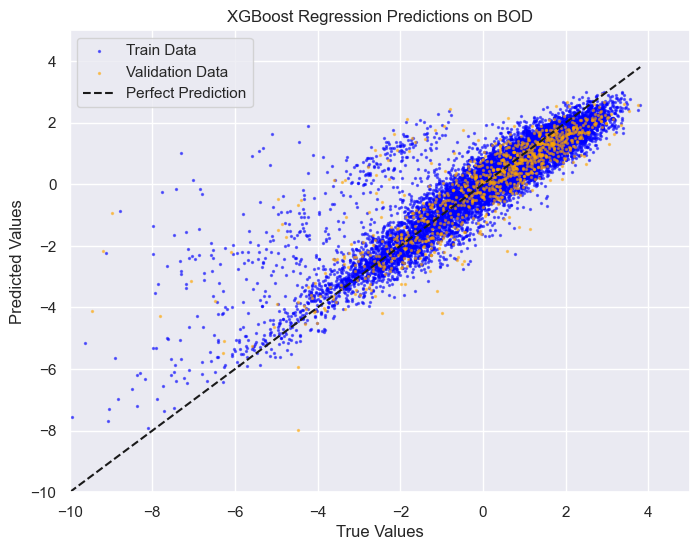

In [24]:
#xgboost on BOD
xgb_bod = XGBRegressor(n_estimators=1000, learning_rate=0.01, n_jobs=-1)
xgb_bod.fit(x_bod_train.numpy(), t_bod_train.numpy())
y_bod_xgb = xgb_bod.predict(x_bod_train.numpy())
y_bod_xgb = torch.tensor(y_bod_xgb, dtype=torch.float32)
y_val_bod_xgb = xgb_bod.predict(x_bod_val.numpy())
y_val_bod_xgb = torch.tensor(y_val_bod_xgb, dtype=torch.float32)
# Compute metrics for XGBoost on BOD
mae_bod_xgb = mean_absolute_error(t_bod_train.numpy(), y_bod_xgb.numpy())
mse_bod_xgb = mean_squared_error(t_bod_train.numpy(), y_bod_xgb.numpy())
r2_bod_xgb = r2_score(t_bod_train.numpy(), y_bod_xgb.numpy())
print(f"XGBoost BOD TRAIN: MAE: {mae_bod_xgb:.4f}, MSE: {mse_bod_xgb:.4f}, R2: {r2_bod_xgb:.4f}")
mae_val_bod_xgb = mean_absolute_error(t_bod_val.numpy(), y_val_bod_xgb.numpy())
mse_val_bod_xgb = mean_squared_error(t_bod_val.numpy(), y_val_bod_xgb.numpy())
r2_val_bod_xgb = r2_score(t_bod_val.numpy(), y_val_bod_xgb.numpy())
print(f"XGBoost BOD VAL: MAE: {mae_val_bod_xgb:.4f}, MSE: {mse_val_bod_xgb:.4f}, R2: {r2_val_bod_xgb:.4f}")
plt.figure(figsize=(8, 6))
plt.scatter(t_bod_train.numpy(), y_bod_xgb.numpy(), alpha=0.5,
            label='Train Data', color='blue', s=2)
plt.scatter(t_bod_val.numpy(), y_val_bod_xgb.numpy(), alpha=0.5,
            label='Validation Data', color='orange', s=2)
plt.plot([t_bod_train.min(), t_bod_train.max()],
         [t_bod_train.min(), t_bod_train.max()], 'k--', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost Regression Predictions on BOD')
plt.legend()
plt.xlim(-10, 5)
plt.ylim(-10, 5)
plt.show()


# BON + BOP

In [44]:
from ACAgraphML.Transforms import BagOfPathsTransform

In [64]:
maxK = 10

bagOfPathTransform = BagOfPathsTransform(maxPathLength=10, logResults=False)
bop_train = [bagOfPathTransform(graph).x for graph in dataset_train]
bop_train = torch.stack(bop_train, dim=0)
bop_val = [bagOfPathTransform(graph).x for graph in dataset_val]
bop_val = torch.stack(bop_val, dim=0)

x_bop_train = torch.cat((x, bop_train), dim=1)
t_bop_train = t

x_bop_val = torch.cat((x_val, bop_val), dim=1)
t_bop_val = t_val
print(x_bop_train.shape, t_bop_train.shape)
print(x_bop_val.shape, t_bop_val.shape)


torch.Size([10000, 30]) torch.Size([10000])
torch.Size([1000, 30]) torch.Size([1000])


In [65]:
bop_train[0].unsqueeze(0).shape

torch.Size([1, 9])

RF BOP TRAIN: MAE: 0.2543, MSE: 0.2031, R2: 0.9498
RF BOP VAL: MAE: 0.7059, MSE: 1.5453, R2: 0.6077


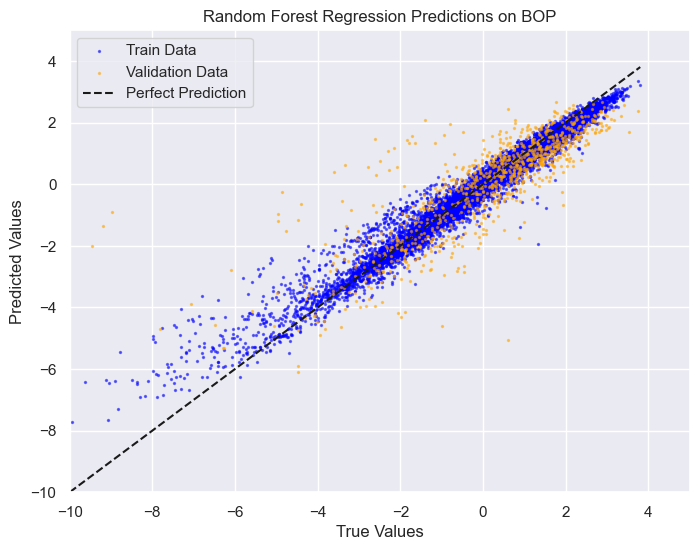

In [66]:
#Random forest on BOP
rf_bop = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
rf_bop.fit(x_bop_train.numpy(), t_bop_train.numpy())
y_bop = rf_bop.predict(x_bop_train.numpy())
y_bop = torch.tensor(y_bop, dtype=torch.float32)

y_val_bop = rf_bop.predict(x_bop_val.numpy())
y_val_bop = torch.tensor(y_val_bop, dtype=torch.float32)
# Compute metrics for Random Forest on BOP
mae_bop = mean_absolute_error(t_bop_train.numpy(), y_bop.numpy())
mse_bop = mean_squared_error(t_bop_train.numpy(), y_bop.numpy())
r2_bop = r2_score(t_bop_train.numpy(), y_bop.numpy())
print(f"RF BOP TRAIN: MAE: {mae_bop:.4f}, MSE: {mse_bop:.4f}, R2: {r2_bop:.4f}")
mae_val_bop = mean_absolute_error(t_bop_val.numpy(), y_val_bop.numpy())
mse_val_bop = mean_squared_error(t_bop_val.numpy(), y_val_bop.numpy())
r2_val_bop = r2_score(t_bop_val.numpy(), y_val_bop.numpy())
print(f"RF BOP VAL: MAE: {mae_val_bop:.4f}, MSE: {mse_val_bop:.4f}, R2: {r2_val_bop:.4f}")
plt.figure(figsize=(8, 6))
plt.scatter(t_bop_train.numpy(), y_bop.numpy(), alpha=0.5,
            label='Train Data', color='blue', s=2)
plt.scatter(t_bop_val.numpy(), y_val_bop.numpy(), alpha=0.5,
            label='Validation Data', color='orange', s=2)
plt.plot([t_bop_train.min(), t_bop_train.max()],
         [t_bop_train.min(), t_bop_train.max()], 'k--', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression Predictions on BOP')
plt.legend()
plt.xlim(-10, 5)
plt.ylim(-10, 5)
plt.show()

XGBoost BOP TRAIN: MAE: 0.4935, MSE: 0.6199, R2: 0.8467
XGBoost BOP VAL: MAE: 0.6133, MSE: 1.2599, R2: 0.6801


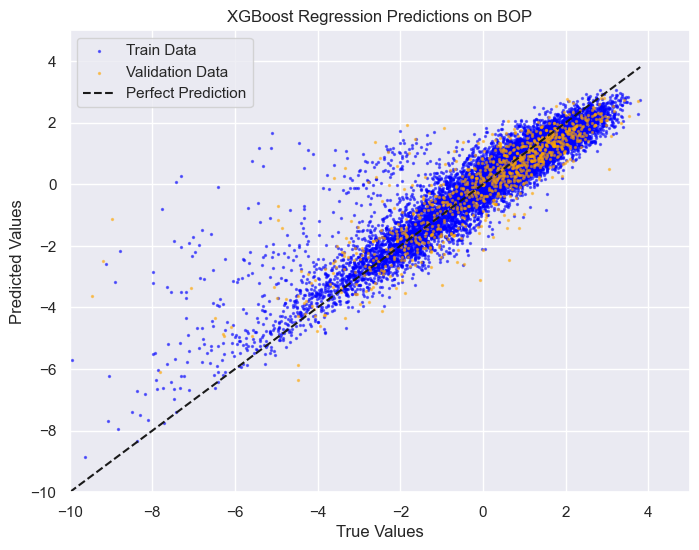

In [67]:
#XgBoost on BOP
xgb_bop = XGBRegressor(n_estimators=1000, learning_rate=0.01, n_jobs=-1)
xgb_bop.fit(x_bop_train.numpy(), t_bop_train.numpy())
y_bop_xgb = xgb_bop.predict(x_bop_train.numpy())
y_bop_xgb = torch.tensor(y_bop_xgb, dtype=torch.float32)
y_val_bop_xgb = xgb_bop.predict(x_bop_val.numpy())
y_val_bop_xgb = torch.tensor(y_val_bop_xgb, dtype=torch.float32)
# Compute metrics for XGBoost on BOP
mae_bop_xgb = mean_absolute_error(t_bop_train.numpy(), y_bop_xgb.numpy())
mse_bop_xgb = mean_squared_error(t_bop_train.numpy(), y_bop_xgb.numpy())
r2_bop_xgb = r2_score(t_bop_train.numpy(), y_bop_xgb.numpy())
print(f"XGBoost BOP TRAIN: MAE: {mae_bop_xgb:.4f}, MSE: {mse_bop_xgb:.4f}, R2: {r2_bop_xgb:.4f}")
mae_val_bop_xgb = mean_absolute_error(t_bop_val.numpy(), y_val_bop_xgb.numpy())
mse_val_bop_xgb = mean_squared_error(t_bop_val.numpy(), y_val_bop_xgb.numpy())
r2_val_bop_xgb = r2_score(t_bop_val.numpy(), y_val_bop_xgb.numpy())
print(f"XGBoost BOP VAL: MAE: {mae_val_bop_xgb:.4f}, MSE: {mse_val_bop_xgb:.4f}, R2: {r2_val_bop_xgb:.4f}")
plt.figure(figsize=(8, 6))
plt.scatter(t_bop_train.numpy(), y_bop_xgb.numpy(), alpha=0.5,
            label='Train Data', color='blue', s=2)
plt.scatter(t_bop_val.numpy(), y_val_bop_xgb.numpy(), alpha=0.5,
            label='Validation Data', color='orange', s=2)
plt.plot([t_bop_train.min(), t_bop_train.max()],
         [t_bop_train.min(), t_bop_train.max()], 'k--', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost Regression Predictions on BOP')
plt.legend()
plt.xlim(-10, 5)
plt.ylim(-10, 5)
plt.show()